In [69]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import  LocalOutlierFactor

In [53]:

# Create a function that takes string input of a SQL query and output a dataframe contain the desired data.
def query_from_db(query):
    # Connection to the posrgreSQL in the airflow container.
    connection = psycopg2.connect(
            host="localhost",
            dbname="airflow",
            port=5532,
            user="postgres",
            password="postgres",
        )
    
    cursor = connection.cursor()
    cursor.execute(query)

    # Get the data from the cursor and make a dataframe for it.
    history_rows = cursor.fetchall()
    df = pd.DataFrame(history_rows)

    # Close the connection,
    cursor.close()
    connection.close()

    return df

In [54]:
# select all ids in table = ethereum
eth = query_from_db("SELECT id, timestamp, price, market_cap, total_volume from coingecko_historic WHERE id = 'ethereum'")
# select all ids in table = bitcoin
btc = query_from_db("SELECT id, timestamp, price, market_cap, total_volume from coingecko_historic WHERE id = 'bitcoin'")

In [55]:
# rename columns from range index
eth.columns = ['id', 'timestamp', 'price', 'market_cap', 'total_volume']
btc.columns = ['id', 'timestamp', 'price', 'market_cap', 'total_volume']

In [56]:
# cast timestamp from int to str
btc['timestamp'] = btc['timestamp'].astype(str)
eth['timestamp'] = eth['timestamp'].astype(str)

In [57]:
# convert unix into a readable format 

btc['dt'] = pd.to_datetime(btc['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
eth['dt'] = pd.to_datetime(eth['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

In [58]:
# remove timezone info and truncate to seconds

btc['dt'] = btc['dt'].dt.floor('S').dt.tz_localize(None)
eth['dt'] = eth['dt'].dt.floor('S').dt.tz_localize(None)

In [66]:
# make sure in chronological order
btc.sort_values(by='dt', ascending = True, inplace = True)
eth.sort_values(by='dt', ascending = True, inplace = True)

In [67]:
# resolve duplicate values if there are any 

# check timestamps-- all timestamps SHOULD be unique, otherwise drop them 
btc_dupe = btc.duplicated(subset=['timestamp'])
eth_dupe = eth.duplicated(subset=['timestamp'])

if len(btc_dupe) > 1:
    bitcoin = btc.loc[~btc_dupe]
    print("Resolved duplicate values in BTC table")

if len(eth_dupe) > 1:
    ethereum = eth.loc[~eth_dupe]
    print("Resolved duplicate values in ETH table")

Resolved duplicate values in BTC table
Resolved duplicate values in ETH table


Text(0.5, 1.0, 'Ethereum Price from Jan to May 2023')

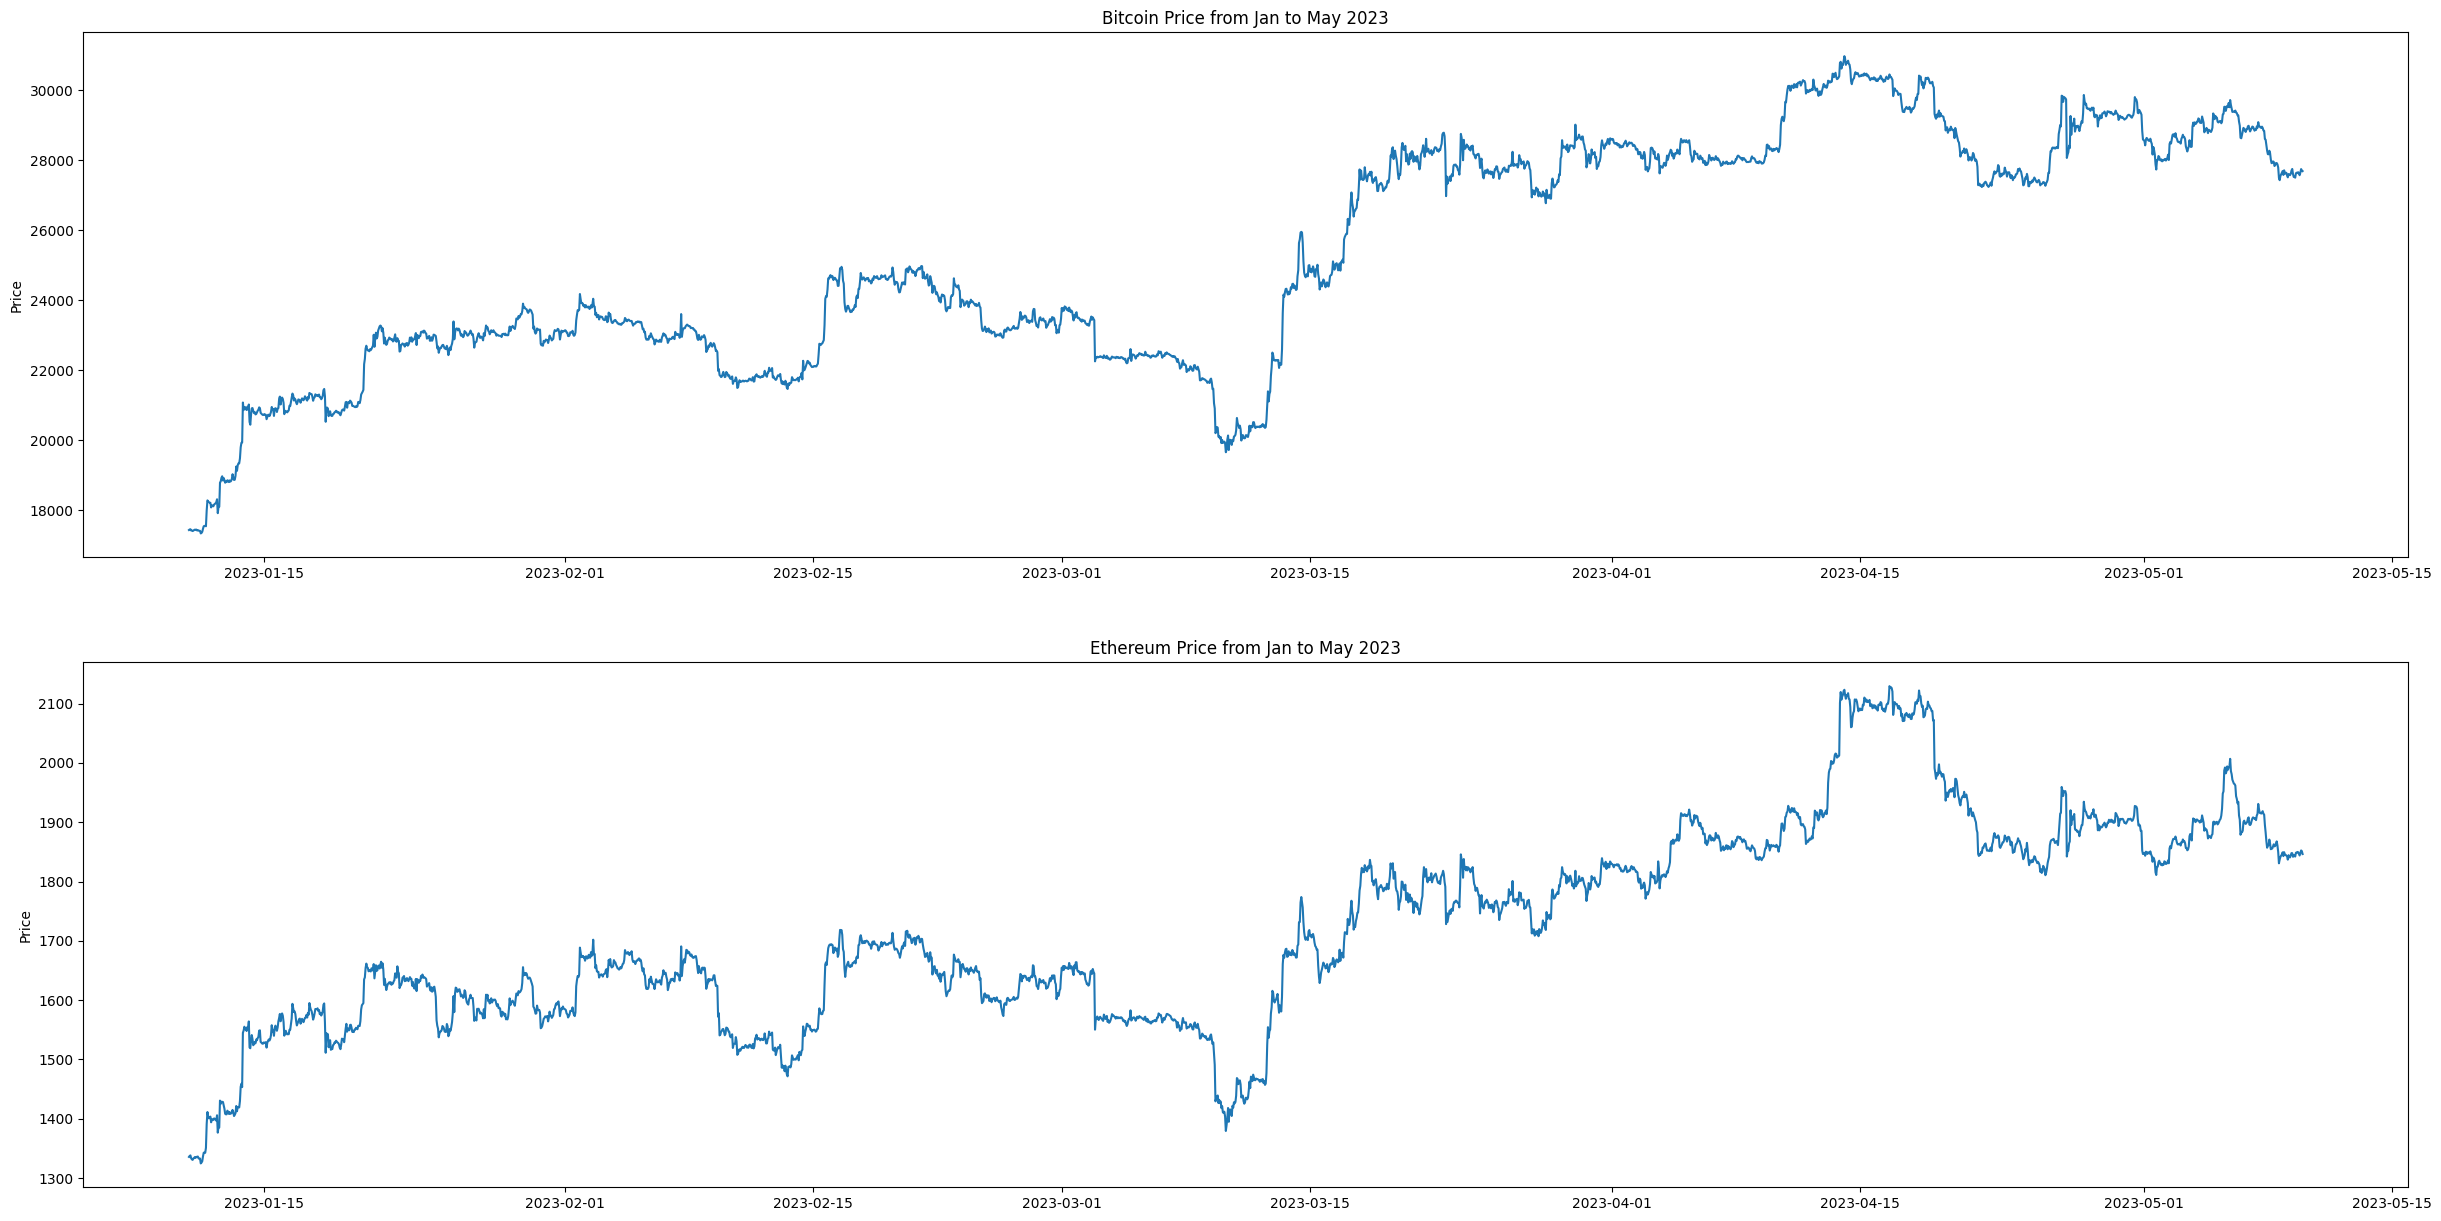

In [68]:
# plot price over time 

plt.figure(figsize = [30,15])
%matplotlib inline 
# displaying the image
plt.subplot(2,1,1)
plt.plot(bitcoin.dt, bitcoin.price)
plt.ylabel("Price")
plt.title("Bitcoin Price from Jan to May 2023")

plt.subplot(2,1,2)
plt.plot(ethereum.dt, ethereum.price)
plt.ylabel("Price")
plt.title("Ethereum Price from Jan to May 2023")

Text(0.5, 1.0, 'Ethereum Volume from Jan to May 2023')

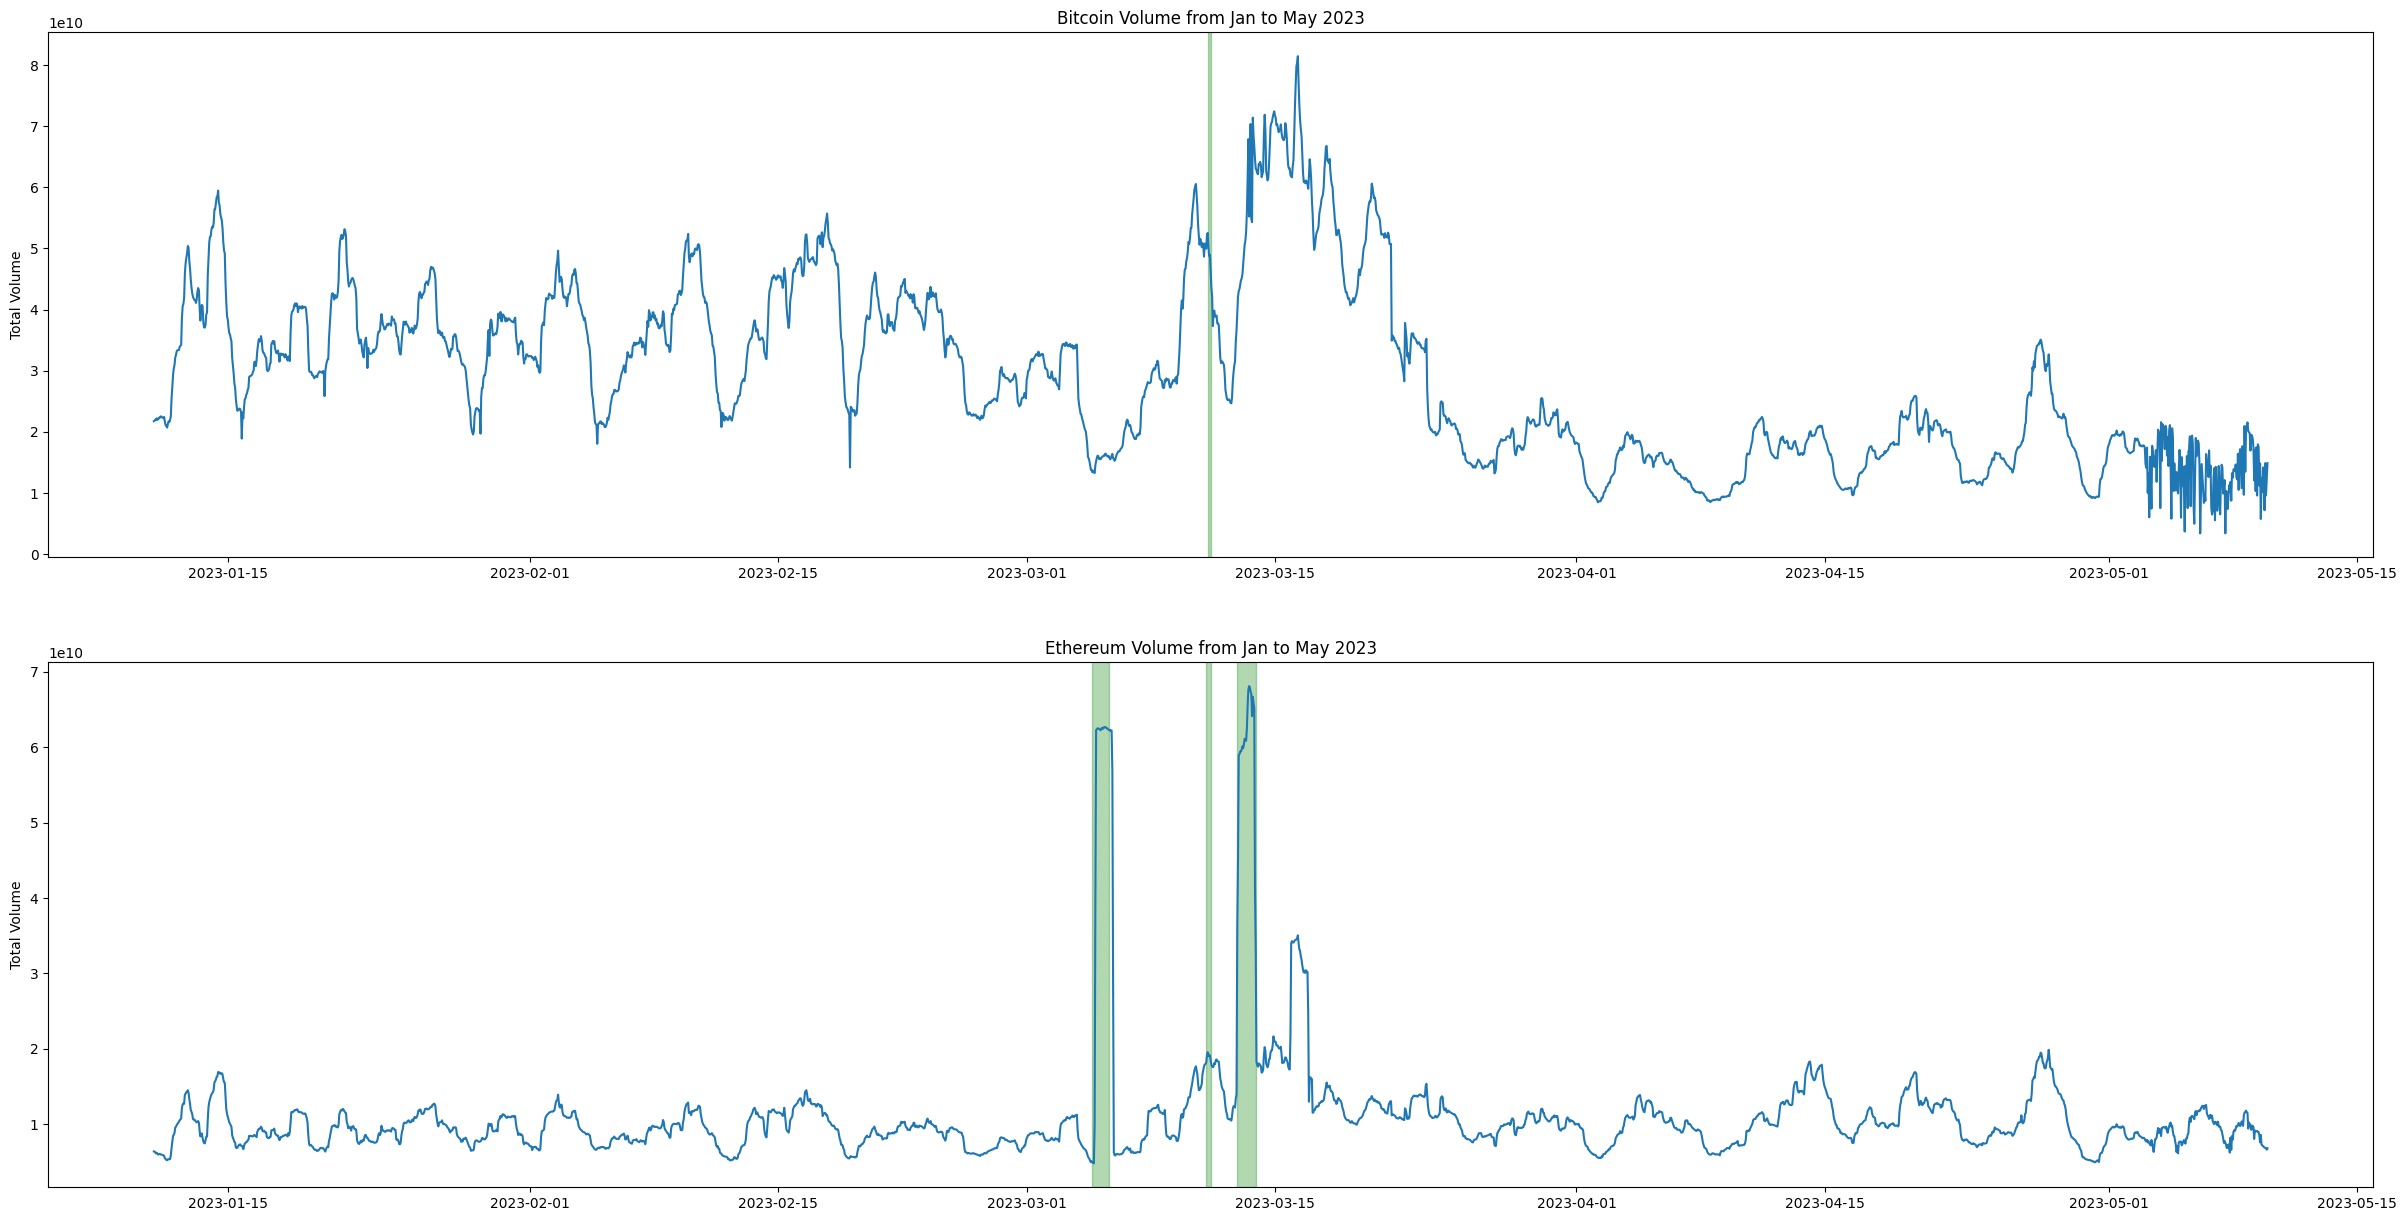

In [130]:
# plot volume over time 

# volume the number of units traded in a market during a given time
# it is a measurement of the number of individual units of an asset that changed hands during that period

plt.figure(figsize = [30,15])
%matplotlib inline 
# displaying the image
plt.subplot(2,1,1)
plt.plot(bitcoin.dt, bitcoin.total_volume)
plt.axvspan(bitcoin.dt[1432], bitcoin.dt[1436], 
            label="Labeled",color="green", alpha=0.3, ymin=0, ymax=1e10)
plt.ylabel("Total Volume")
plt.title("Bitcoin Volume from Jan to May 2023")

plt.subplot(2,1,2)
plt.plot(ethereum.dt, ethereum.total_volume)
plt.axvspan(ethereum.dt[1274], ethereum.dt[1297], 
            label="Labeled",color="green", alpha=0.3, ymin=0, ymax=1e10)
plt.axvspan(ethereum.dt[1431], ethereum.dt[1437], 
            label="Labeled",color="green", alpha=0.3, ymin=0, ymax=1e10)
plt.axvspan(ethereum.dt[1471], ethereum.dt[1497], 
            label="Labeled",color="green", alpha=0.3, ymin=0, ymax=1e10)
plt.ylabel("Total Volume")
plt.title("Ethereum Volume from Jan to May 2023")

In [72]:
# One way to think about market cap is as a rough gauge for how stable an asset is likely to be

In [103]:
ethereum.reset_index(inplace=True)
bitcoin.reset_index(inplace=True)

In [104]:
# check for outliers in volume

lof = LocalOutlierFactor(n_neighbors=25, contamination=0.05)

btcvol_score = lof.fit_predict(bitcoin[['total_volume']])
bitcoin['outlier'] = btcvol_score

/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_4451/3645080787.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin['outlier'] = btcvol_score


In [105]:
ethvol_score = lof.fit_predict(ethereum[['total_volume']])
ethereum['outlier'] = ethvol_score

/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_4451/512874743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethereum['outlier'] = ethvol_score


In [106]:
bitcoin.loc[bitcoin['outlier']==-1]

,index,id,timestamp,price,market_cap,total_volume,dt,outlier
36,2220,bitcoin,1673524813065,18199.104806202147,350571856055.94354,34075154808.715427,2023-01-12 07:00:13,-1
61,2245,bitcoin,1673614910907,18869.97231896958,363937598327.6456,43163319613.279045,2023-01-13 08:01:50,-1
78,2262,bitcoin,1673676011987,20869.370693984514,402313358582.347,53127351351.13694,2023-01-14 01:00:11,-1
79,2263,bitcoin,1673679602027,20962.260990938234,402630775170.17053,53556331354.723854,2023-01-14 02:00:02,-1
80,2264,bitcoin,1673683282224,20883.91006002229,401923894991.91364,53441812771.907425,2023-01-14 03:01:22,-1
...,...,...,...,...,...,...,...,...
2832,2151,bitcoin,1683572419506,27504.510339272143,532714892023.39966,9709029940.006447,2023-05-08 15:00:19,-1
2850,2169,bitcoin,1683637208072,27756.293586200012,537525404333.9414,9574144745.40356,2023-05-09 09:00:08,-1
2855,2174,bitcoin,1683655221836,27633.09853186977,535329202123.99786,5743355714.408432,2023-05-09 14:00:21,-1
2860,2179,bitcoin,1683673237881,27577.36086358994,534161955089.65704,7172655650.55621,2023-05-09 19:00:37,-1


In [107]:
ethereum.loc[ethereum['outlier']==-1]

,index,id,timestamp,price,market_cap,total_volume,dt,outlier
12,2197,ethereum,1673438516108,1336.3415345574572,160920507009.86014,5918061546.761397,2023-01-11 07:01:56,-1
13,2198,ethereum,1673442076523,1333.1576347910307,160750623810.69577,5867977663.084089,2023-01-11 08:01:16,-1
23,2208,ethereum,1673478069520,1350.9760583802197,163026162383.40158,5876775343.723095,2023-01-11 18:01:09,-1
28,2213,ethereum,1673496023299,1401.5092445446671,169032980234.45755,8840053566.405613,2023-01-11 23:00:23,-1
78,2263,ethereum,1673676128687,1547.9500773294528,186647283617.77408,13960048455.172743,2023-01-14 01:02:08,-1
...,...,...,...,...,...,...,...,...
2670,1988,ethereum,1682982003952,1825.0144967889062,219924011889.79642,9716915766.895834,2023-05-01 19:00:03,-1
2682,1376,ethereum,1683025223005,1830.1439136533413,220399951445.61752,8090457282.2196245,2023-05-02 07:00:23,-1
2688,2006,ethereum,1683046847104,1855.9763712778738,223621519082.21548,8852471909.659763,2023-05-02 13:00:47,-1
2689,2007,ethereum,1683050441488,1863.243362207271,223863637847.50137,8830464859.335012,2023-05-02 14:00:41,-1
